# HyperNets

Needing to explore different architectures for a given problem is a common use-case. Many a times, it is a trial and error process where one has to try different configurations of a given architecture and then finally select one that suits a particular porblem.

This notebook explores an idea that allows one to explore different architectures in a very efficient way.

A network of two fully connceted layers for classifying digits from MNIST dataset is used as the example.

The main sturucture:

* Import required packages
* Create dataloaders for the MNIST dataset
* Define a Baseline model that could be trained for different configurations
* Train few versions of Baseline models to have an idea of possible accuracies achievable
* Define a HyperNet that allows easy architectural design space exploration
* Train HyperNet and explore the validation accuracy for different configurations
* Create prunned models from the trained HyperNet
* Compare the classification of prunned model to a baseline model of similar configuration


## Idea

Is there redundancy in neural networks? How much redundancy is there in a given model for a given application? These were some of the questions that I wanted to explore in this Notebook.

So, to explore the redundancy, one could try to get good enough accuracy by selectively training only parts of a model. However, the model should have enough width for it to utilize more resources if really needed.

The main idea that I tired is to break each layer in segments. The architecture allows for one to train only a portion of the segments. The layer can be dynamically or randomly split between portions that are trained and ignored every training batch.

So, if there is lots of redundancy in the model then it should be possible to achieve good accuracy by activating only a portion of the architecture during validation or testing.

## Section A - Explore the space and establish the baseline

In this section, a normal model is defined, trained, and evaluated to establish the baseline.

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import seaborn as sns

import math
import random

In [2]:
# Define transformation used for the normalization of the images from the MNIST dataset

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
# Create test and validation dataset loaders
batch_size = 64
trainset = datasets.MNIST('data/t-mnist', download=True, train=True, transform=transform)
valset = datasets.MNIST('data/v-mnist', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

In [4]:
# Check the size of samples and labels in the dataset
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


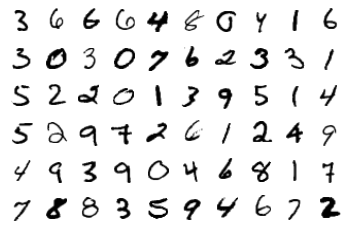

In [5]:
# Visualize a few of the images from the MNIST dataset

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

### BaselineModel

In [6]:
# This class can be used to define models with two hidden layers of configurable sizes.

class BaselineModel(nn.Module):
    def __init__(self, in_size, hidden_layer_sizes, out_size):
        super(BaselineModel, self).__init__()

        self.layers = nn.ModuleList()

        prev_layer_output_size = in_size
        for hidden_layer_size in hidden_layer_sizes:
            self.layers.append(nn.Linear(prev_layer_output_size, hidden_layer_size))
            self.layers.append(nn.ReLU())

            prev_layer_output_size = hidden_layer_size

        self.layers.append(nn.Linear(prev_layer_output_size, out_size))
        self.layers.append(nn.LogSoftmax(dim=1))

        self.model = nn.Sequential(*self.layers)

    def forward(self, samples, extra_model_args = None):
        return self.model(samples.view(samples.shape[0], -1))

### Utility functions

In [7]:
# Function for training a model for one epoch

def train(model, criterion, optimizer, trainloader, extra_model_args = None):

    model.train()

    all_loss = 0
    correct_count, all_count = 0, 0

    for inputs, labels in trainloader:
        # Training pass
        optimizer.zero_grad()
        
        if extra_model_args == None:
            outputs = model(inputs)
        else:
            outputs = model(inputs, extra_model_args)
        
        loss = criterion(outputs, labels)
        
        #This is where the model learns by back-propagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        # Calculate validation accuracy
        _, predictions = torch.max(outputs.data, 1)
        correct_preds = predictions.eq(labels.data.view_as(predictions))

        # Convert correct_counts to float and then compute the mean
        batch_avg_acc = torch.mean(correct_preds.type(torch.FloatTensor))

        # Compute total accuracy in the whole batch and add to valid_acc
        correct_count += batch_avg_acc.item() * inputs.size(0)
        
        all_loss += loss.item() * inputs.shape[0]
        all_count += inputs.size(0)
        
    return (all_loss / all_count, correct_count / all_count)

In [8]:
# Function for running a validation run

def validate(model, criterion, valloader, extra_model_args = None):

    model.eval()

    all_loss = 0
    correct_count, all_count = 0, 0

    for inputs, labels in valloader:
        with torch.no_grad():
            if extra_model_args == None:
                outputs = model(inputs)
            else:
                outputs = model(inputs, extra_model_args)
            
            loss = criterion(outputs, labels)
            
            # Calculate validation accuracy
            _, predictions = torch.max(outputs.data, 1)
            correct_preds = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            batch_avg_acc = torch.mean(correct_preds.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            correct_count += batch_avg_acc.item() * inputs.size(0)
            
            all_loss += loss.item() * inputs.shape[0]
            all_count += inputs.size(0)
            
    return (all_loss / all_count, correct_count / all_count)

In [9]:
# Define the input and hidden layer sizes

input_size = 784
output_size = 10

### Train BaselineModel

In [10]:
# Let us train the BaselineModel for a few combinations of hidden layers sizes

for hidden_layer_sizes in [[8, 8], [32, 32], [64, 64], [128, 128]]:
    model = BaselineModel(input_size, hidden_layer_sizes, output_size)
    criterion = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
    
    epochs = 50
    for epoch in range(epochs):
        train(model, criterion, optimizer, trainloader)
    loss, accuracy = validate(model, criterion, valloader, None)
    print(f"{hidden_layer_sizes} - loss: {loss}, accuracy: {accuracy}")

[8, 8] - loss: 0.22615321083068848, accuracy: 0.9357
[32, 32] - loss: 0.12899463981315493, accuracy: 0.9681
[64, 64] - loss: 0.1045235980141908, accuracy: 0.975
[128, 128] - loss: 0.07589108820296823, accuracy: 0.979


It takes about 2.5 minutes to do one iteration and there are quite a few limitations with this approach.

* One could use many of the available search methods to search within the space of hyperparameters but each of those attempts requires training multiple models from scratch.
* There seems to be lots of redundancy in the models as there is hardly any improvement in accuracy when the model goes from [32, 32] to [128, 128] size.
* It is not possible to reliably estimate the sufficient number of hidden neurons for a given target efficiency unless one is ready to do some design space exploration.
* It is also not possible to use only the required portion of the model. One needs different models for different levels of fidelity.

This begs the question if there is an efficient way to mitigate some of the limitations mentioned above.

## Section B - Define and explore HyperNet

In this section, an architecture of model is defined that might help explore the design space of hyper-parameters more efficiently.

The core idea is to define a model whose selective portions could be trained or evaluated at will.

### HyperNet Components

There are 3 main components to the HyperNet architecture that I explored.
* HyperNetHiddenLayerSegment - This represents a set of neurons that are trained or ignored together.
* HypeNetHiddenLayer - A sequence of HyperNetLayerSegments of increasing sizes (Fibonacci sequence) that is used to model the hidden layers.
HyperNet - A model architecture composed of HypeNetHiddenLayers
* HyperNetModel - A model that consists of a number of HypeNetHiddenLayers.

<img src="HyperNets.png" alt="HyperNets" style="width: 500px;"/>

In [11]:
# This class represents a segment of a layer consisting of a few neurons that are
# trained or skipped together
class HyperNetHiddenLayerSegment(nn.Module):
    def __init__(self, in_size, out_size):
        super(HyperNetHiddenLayerSegment, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_size, out_size),
            nn.ReLU())

    def forward(self, samples):
        return self.model(samples)

# This class represents a hidden layer that is composed of segments
# that are trained or skipped together.
# The segments are ordered and the probability of training segments
# later keeps decreasing.
class HyperNetHiddenLayer(nn.Module):
    def __init__(self, in_size, segment_sizes):
        super(HyperNetHiddenLayer, self).__init__()
        self._in_size = in_size

        self._segment_sizes = segment_sizes
        self._num_segments = len(segment_sizes)

        self._max_out_size = sum(segment_sizes)

        segments = nn.ModuleList()
        for segment_size in segment_sizes:
            segments.append(HyperNetHiddenLayerSegment(in_size, segment_size))

        self._segments = segments

    def in_size(self):
        return self._in_size

    def max_out_size(self):
        return self._max_out_size

    def num_segments(self):
        return self._num_segments

    def segment_sizes(self):
        return self._segment_sizes

    def forward(self, x_partial, num_active_segments = None):
        # passed in x may not be of the right size
        # expand the x appropriately
        # x_partial.shape is (batch_size, partial_in_size
        x_expanded = torch.zeros(x_partial.shape[0], self._in_size)
        x_expanded[:, :x_partial.shape[1]] = x_partial
        
        # do forward pass only for the requested number segments
        active_segments = self._segments[0:num_active_segments]

        segment_outs = []
        for active_segment in active_segments:
            segment_outs.append(active_segment(x_expanded))

        return torch.cat(segment_outs, dim=1)

class HyperNetModel(nn.Module):
    def __init__(self, input_size, hidden_layers_segment_sizes, output_size):
        super(HyperNetModel, self).__init__()

        self.hidden_layers_segment_sizes = hidden_layers_segment_sizes

        # create hidden adaptive layers
        layers = nn.ModuleList()
        
        prev_layer_size = input_size
        for hidden_segment_sizes in hidden_layers_segment_sizes:
            layers.append(HyperNetHiddenLayer(prev_layer_size, hidden_segment_sizes))
            prev_layer_size = sum(hidden_segment_sizes)

        # create output layer
        self._last_in_size = prev_layer_size
        layers.append(nn.Sequential(
            nn.Linear(prev_layer_size, output_size),
            nn.LogSoftmax(dim=1)))

        self.layers = layers

    def forward(self, samples, extra_model_args = None):
        x_partial = samples.view(-1, 28*28)

        # iterate over layers
        num_layers = len(self.layers)
        for lIdx in range(num_layers):
            layer = self.layers[lIdx]
            if lIdx != (num_layers - 1):
                if extra_model_args == "random":
                    num_active_segments = np.random.randint(1, layer.num_segments() + 1) # right limit is exclusive
                elif extra_model_args == "all":
                    num_active_segments = layer.num_segments()
                else:
                    num_active_segments = extra_model_args[lIdx]
                    
                # input will be extended as required by the layer itself
                x_partial = layer.forward(x_partial, num_active_segments) 
            else:
                # last layer
                x_expanded = torch.zeros(x_partial.shape[0], self._last_in_size)
                x_expanded[:, :x_partial.shape[1]] = x_partial
                x_partial = layer.forward(x_expanded)

        return x_partial # will be the right size after the last layer




In [12]:
# Function to return a give number of repetitions of a given number

def get_reps(num, size):
    parts = []
    for idx in range(num):
        parts.append(size)
    
    return parts, sum(parts)

In [13]:

def get_hidden_layer_segment_sizes_uisng_reps(hidden_layers_num_segments, segment_size):
    hidden_layers_segment_sizes = []
    for hidden_layer_num_segments in hidden_layers_num_segments:
        hidden_layers_segment_sizes.append(get_reps(hidden_layer_num_segments, segment_size)[0])
        
    return hidden_layers_segment_sizes


hidden_layers_num_segments = [20, 20]
segment_size = 8

hidden_layers_segment_sizes = \
    get_hidden_layer_segment_sizes_uisng_reps(hidden_layers_num_segments, segment_size)
    
print(hidden_layers_segment_sizes)

[[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]]


When a section of the segments is randomly selected for training, the different neurons will have different probability of being trainned. Let us expplore that a bit.

In [14]:
num_samples = 500
neurons_trained = []

first_hidden_layer_segment_sizes = hidden_layers_segment_sizes[0]
num_segments_first_hidden_layer = len(first_hidden_layer_segment_sizes)

for i in range(num_samples):
    num_segments = np.random.randint(1, num_segments_first_hidden_layer + 1) # right limit is exclusive
    segment_sizes = first_hidden_layer_segment_sizes[0:num_segments]
    num_neurons = sum(segment_sizes)
    neurons_trained.append(num_neurons)


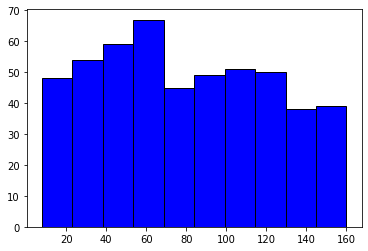

In [15]:
num_bins = 20
f1 = plt.figure()
plt.hist(neurons_trained, color = 'blue', edgecolor = 'black',
         bins = 10)
plt.show()


It can be observed that the number of neurons that are randomly trained are likely to be uniformly distributed.

### Training of HyperNetModel

In [16]:
model = HyperNetModel(input_size, hidden_layers_segment_sizes, output_size)

criterion = nn.NLLLoss()

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [18]:
# Train the HyperNetModel
# The number of segments to be trained in both the hidden layers vary from batch to batch randomly.

epochs = 50

for epoch in range(epochs):
    t_l, t_a = train(model, criterion, optimizer, trainloader, "random")
    v_l, v_a = validate(model, criterion, valloader, "all")

    train_losses.append(t_l)
    train_accuracies.append(t_a)
    val_losses.append(v_l)
    val_accuracies.append(v_a)
    # print(f"Epoch {epoch}: train loss = {t_l}, train accuracy = {t_a}, validation loss = {v_l}, validation accuracy = {v_a}")

It takes about 4 minutes to train the HyperNetModel on my MacBook Pro, 2021.

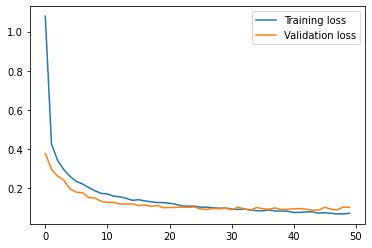

In [19]:
# Plot the training and validation loss curves
f2 = plt.figure()
plt.plot(range(len(train_losses)), train_losses, label='Training loss')
plt.plot(range(len(train_losses)), val_losses, label='Validation loss')
plt.legend()

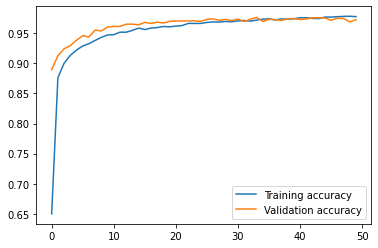

In [20]:
# Plot the training and validation accuracy curves
f3 = plt.figure()
plt.plot(range(len(train_accuracies)), train_accuracies, label='Training accuracy')
plt.plot(range(len(val_accuracies)), val_accuracies, label='Validation accuracy')
plt.legend()

In [21]:
if False:
    torch.save(model.state_dict(), "./HyperNetModel-MNIST.model")

In [22]:

hidden_layers_active_segments = []
for fIdx in range(len(hidden_layers_segment_sizes[0])):
    for sIdx in range(len(hidden_layers_segment_sizes[0])):
        hidden_layers_active_segments.append([fIdx + 1, sIdx + 1])

In [23]:

layer_size_and_accuracies = []
for hidden_layer_active_segments in hidden_layers_active_segments:
    loss, accuracy = validate(model, criterion, valloader, hidden_layer_active_segments)

    f_num_active_segments = hidden_layer_active_segments[0]
    s_num_active_segments = hidden_layer_active_segments[1]
    f_num_active_neurons = sum(hidden_layers_segment_sizes[0][0:f_num_active_segments])
    s_num_active_neurons = sum(hidden_layers_segment_sizes[1][0:s_num_active_segments])

    layer_size_and_accuracies.append([f_num_active_neurons, s_num_active_neurons, accuracy])
    # print(f"{hidden_layer_active_segments} : {accuracy}")


In [24]:
my_data = np.array(layer_size_and_accuracies)

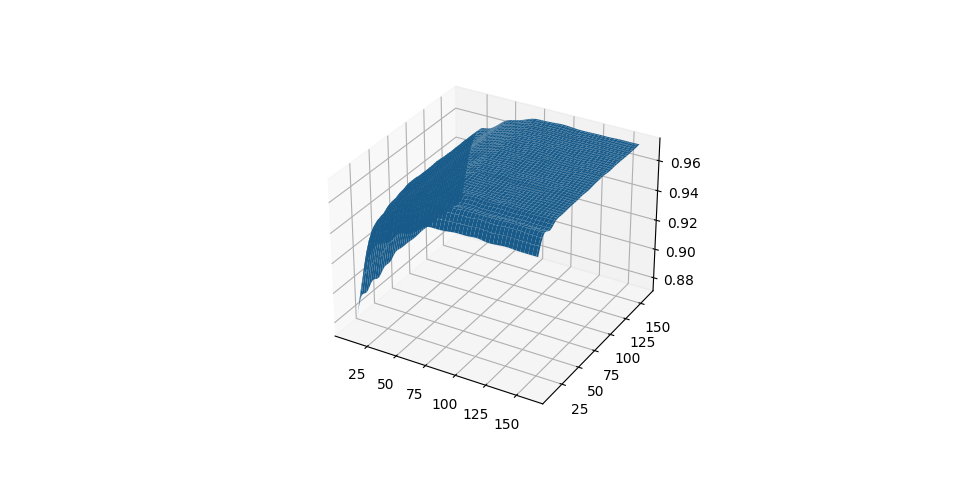

In [33]:
# %matplotlib widget

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

fig = plt.figure(figsize=plt.figaspect(0.5))

X = my_data[:,0]
Y = my_data[:,1]
Z = my_data[:,2]

xi = np.linspace(X.min(),X.max(),100)
yi = np.linspace(Y.min(),Y.max(),100)
# VERY IMPORTANT, to tell matplotlib how is your data organized
zi = griddata((X, Y), Z, (xi[None,:], yi[:,None]), method='cubic')

ax = fig.add_subplot(1, 1, 1, projection='3d')

xig, yig = np.meshgrid(xi, yi)

surf = ax.plot_surface(xig, yig, zi,
        linewidth=0)


We can observe in the plot above that accuracy increases rapidly initially and then plateus. This indicates that there is lots of redundancy in the model.

Let us now show another plot where the number of active layers increase together in both of the layers.

In [26]:

hidden_layers_active_segments = []
for fIdx in range(len(hidden_layers_segment_sizes[0])):
        hidden_layers_active_segments.append([fIdx + 1, fIdx + 1])
        
layer_sizes = []
accuracies = []
for hidden_layer_active_segments in hidden_layers_active_segments:
    loss, accuracy = validate(model, criterion, valloader, hidden_layer_active_segments)

    num_active_segments = hidden_layer_active_segments[0]
    num_active_neurons = sum(hidden_layers_segment_sizes[0][0:num_active_segments])

    layer_sizes.append(num_active_neurons)
    accuracies.append(accuracy)
    # print(f"{hidden_layer_active_segments} : {accuracy}")


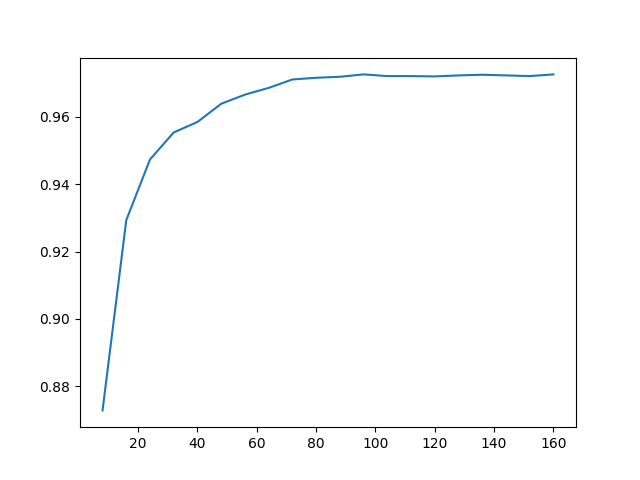

In [31]:
# Plot the training and validation accuracy curves
f4 = plt.figure()
plt.plot(layer_sizes, accuracies, label='Validation accuracy')

It seems evident that there is insignificant increase in accuracy beyond hidden layer sizes of about 80.

It would be interesting to verify the accuracy using prunned models constructed from the wights of the trained model and finally compare that to a BaselineModel of the same size.

In [28]:
# Print state dict as loaded

model_dict_raw = torch.load("HyperNetModel-MNIST.model.lkg")

# for param_tensor in model_dict_raw:
#    print(param_tensor, "\t", model_dict_raw[param_tensor].size())

Now, let us explore the effect of using only the pruned models that are obtained from the HyperNetModel weights.

In [29]:
for num_segments in [2, 8, 14, 20]:
    # Prepare model dict

    prunned_hidden_layers_segment_sizes = \
        get_hidden_layer_segment_sizes_uisng_reps([num_segments, num_segments], segment_size)

    fls = sum(prunned_hidden_layers_segment_sizes[0]) # neurons
    sls = sum(prunned_hidden_layers_segment_sizes[1]) # neurons

    # Iterate model's state_dict and
    # build one for the partial model
    model_dict = {}

    partial_layer_sizes = [input_size, fls, sls]
    for idx in range(len(prunned_hidden_layers_segment_sizes)):
        partial_layer_input_size = partial_layer_sizes[idx]
        partial_hidden_layer_segment_sizes = prunned_hidden_layers_segment_sizes[idx]
        for sIdx in range(len(partial_hidden_layer_segment_sizes)):
            partial_hidden_layer_segment_size = partial_hidden_layer_segment_sizes[sIdx]
            # copy weights and biases
            key_base = "layers." + str(idx) + "._segments." + str(sIdx) + ".model.0."
            model_dict[key_base + "weight"] = model_dict_raw[key_base + "weight"][:, :partial_layer_input_size]
            model_dict[key_base + "bias"] = model_dict_raw[key_base + "bias"][:partial_layer_input_size]

    # last layer
    model_dict["layers.2.0.weight"] = model_dict_raw["layers.2.0.weight"][:, :sls]
    model_dict["layers.2.0.bias"] = model_dict_raw["layers.2.0.bias"][:sls]

    # for param_tensor in model_dict:
    #     print(param_tensor, "\t", model_dict[param_tensor].size())

    #print(model.state_dict()['layers.2.0.weight'].shape)


    model_pruned = HyperNetModel(input_size, prunned_hidden_layers_segment_sizes, output_size)

    model_pruned.load_state_dict(model_dict)

    criterion_pruned = nn.NLLLoss()

    # Get the accuracy from the pruned model
    pruned_loss, pruned_accuracy = validate(model_pruned, criterion_pruned, valloader, "all")

    # Get the accuracy from the BaselineModel
    model_baseline = BaselineModel(input_size, [fls, sls], output_size)
    criterion_baseline = nn.NLLLoss()
    optimizer_baseline = optim.SGD(model_baseline.parameters(), lr=0.003, momentum=0.9)

    epochs = 50

    for epoch in range(epochs):
        train(model_baseline, criterion_baseline, optimizer_baseline, trainloader)

    _, baseline_accuracy = validate(model_baseline, criterion_baseline, valloader, None)

    print(f"Pruned model: size = {num_segments * segment_size}, accuracy = {pruned_accuracy}, Baseline accuracy = {baseline_accuracy}")


Pruned model: size = 16, accuracy = 0.931, Baseline accuracy = 0.9531
Pruned model: size = 64, accuracy = 0.9722, Baseline accuracy = 0.9739
Pruned model: size = 112, accuracy = 0.9749, Baseline accuracy = 0.9785
Pruned model: size = 160, accuracy = 0.9749, Baseline accuracy = 0.9806


## Conclusion

### Exploration efficiency and robust approximation
In this notebook, I explored a new Neural Network architecture with a capability to train and use different segments of the hidden layers. This architecture is able to approximate the performace of different instances of BaselineModel with fixed sizes of hidden layers. It is clear that a single instance of HyperNetModel can be used to explore the behavior of hundreds of BaselineModel instances with just one traning sprint. The validation accuracy of the prunned versions of the HyperNetModel is close to the performance of the BaselineModels within a few percentage points. It can also be observed that the difference in accuracy diminishes with the increasing sizes of the hidden layers. 

## Next what?

This work could be have some continuations and a few of those are given below.

* It will be interesting to explore this idea further with Convolutional Neural Networks.
* Explore the Mathematics that can explain the emperically obtained results
* Improving the accuracy of the prunned models by training for a few additional epochs
* Finding the optimal configuration(s) during training that exhibit maximum potential for generalization